### ✅ Phase 1 – Step 1: Convert 100 .dcm files → .png

In [1]:
import os
import pydicom
import cv2

# Folder where your DICOM files are
dcm_folder = '12B_XCT'
output_folder = 'converted_pngs'

# Create output folder if it doesn't exist
os.makedirs(output_folder, exist_ok=True)

# Get list of .dcm files (sorted to maintain slice order)
dcm_files = sorted([f for f in os.listdir(dcm_folder) if f.endswith('.dcm')])

# Convert first 100 DICOM slices to PNG
for i in range(100):
    dcm_path = os.path.join(dcm_folder, dcm_files[i])
    img = pydicom.dcmread(dcm_path).pixel_array
    
    # Normalize pixel values to 0-255 (8-bit image)
    img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)
    img_uint8 = img_normalized.astype('uint8')
    
    # Save as PNG
    out_path = os.path.join(output_folder, f'slice_{i}.png')
    cv2.imwrite(out_path, img_uint8)

print("✅ Done! 100 PNG images saved in 'converted_pngs/' folder.")


✅ Done! 100 PNG images saved in 'converted_pngs/' folder.


### 🔁 Phase 1 – Step 2: Augment 100 Images → 1000 Images

In [2]:
import albumentations as A
import cv2
import os

# Input/output folders
input_folder = 'converted_pngs'
output_folder = 'augmented'
os.makedirs(output_folder, exist_ok=True)

# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussNoise(p=0.3),
])

# Loop through each image and apply 10 augmentations
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        # Create 10 augmented versions
        for i in range(10):
            augmented = transform(image=image)['image']
            new_name = f"{filename[:-4]}_aug_{i}.png"
            new_path = os.path.join(output_folder, new_name)
            cv2.imwrite(new_path, augmented)

print("✅ All images augmented — you now have 1000 images in 'augmented/' folder.")

✅ All images augmented — you now have 1000 images in 'augmented/' folder.


### 🧠 Phase 2 – Choose Your Model Type

### ✅ We will use path 1: U-Net segmentation

### 🧠 Phase 2 – Step 1: Create Segmentation Masks (Using Thresholding)

In [3]:
import os
import cv2
import numpy as np

input_folder = 'augmented'
mask_folder = 'masks'
os.makedirs(mask_folder, exist_ok=True)

# Loop through all augmented images
for filename in os.listdir(input_folder):
    if filename.endswith('.png'):
        img_path = os.path.join(input_folder, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        # Apply simple threshold to get pores as white (255)
        _, mask = cv2.threshold(img, 100, 255, cv2.THRESH_BINARY_INV)

        # Save the mask
        mask_path = os.path.join(mask_folder, filename)
        cv2.imwrite(mask_path, mask)

print("✅ Done! 1000 binary masks saved in 'masks/' folder.")

✅ Done! 1000 binary masks saved in 'masks/' folder.


### lets see a  Sample Image + Mask

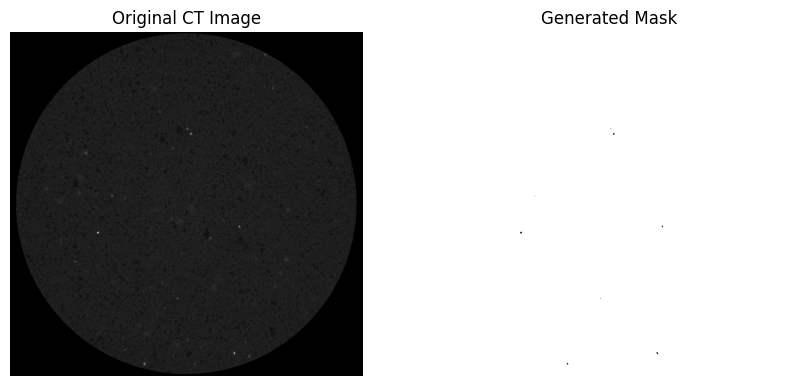

In [27]:
import matplotlib.pyplot as plt

img = cv2.imread('augmented/slice_0_aug_0.png', cv2.IMREAD_GRAYSCALE)
mask = cv2.imread('masks/slice_0_aug_0.png', cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Original CT Image")
plt.imshow(img, cmap='gray')
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Generated Mask")
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.show()

### ✅ Phase 2 – Step 2: Organize Data and Build PyTorch Data Loader

In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class RockSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(image_dir))

    def __len__(self):
        return len(self.image_filenames)
        
    def __getitem__(self, idx):
        # Load image and mask
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.image_filenames[idx])

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # ✅ Resize both image and mask to 256x256
        image = cv2.resize(image, (128, 128))
        mask = cv2.resize(mask, (128, 128))

        # Normalize and add channel dimension
        image = image / 255.0
        mask = mask / 255.0
        image = np.expand_dims(image, axis=0)
        mask = np.expand_dims(mask, axis=0)

        # Convert to tensors
        image = torch.tensor(image, dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32)

        return image, mask

In [ ]:
# Set paths to your folders
image_folder = 'augmented'
mask_folder = 'masks'

# Create dataset
dataset = RockSegmentationDataset(image_folder, mask_folder)

# Create DataLoader (batch size 4, shuffle data)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

# Test: View one batch of image + mask
images, masks = next(iter(dataloader))

print("Image batch shape:", images.shape)
print("Mask batch shape:", masks.shape)

# Visualize first item in batch
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(images[0][0], cmap='gray')
plt.title('Input Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(masks[0][0], cmap='gray')
plt.title('Ground Truth Mask')
plt.axis('off')
plt.show()
